In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import sys; sys.path.insert(0, '../')

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.style.use('science')
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# always import gbm_algos first !
import xgboost, lightgbm, catboost

# Core
import numpy as np
import scipy.io as io
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from mlens.ensemble import SuperLearner

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder
from onecyclelr import OneCycleLR
import pcgrad
from pytorch_stats_loss import torch_wasserstein_loss, torch_energy_loss
from geomloss import SamplesLoss
from utils import *

# Model selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from RegscorePy.bic import bic

from tqdm import trange

[MLENS] backend: threading


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Running Python 3.9.9
You can use npar for np.array


In [2]:
DATA_PATH = "../experimental_data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

# Adding noise
noise_intensity = 0.0
noisy_xt = False

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

if noise_intensity>0.0:
    Exact = perturb(Exact, intensity=noise_intensity, noise_type="normal")
    print("Perturbed Exact with intensity =", float(noise_intensity))
else: print("Clean Exact")

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 3000; include_unsup = True; load_idx = True
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
if load_idx: idx = np.load("./data_files/idx.npy")
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

if noisy_xt and noise_intensity>0.0:
    print("Noisy (x, t)")
    # perturb2d(X_u_train, intensity=noise_intensity)
    X_u_train = perturb(X_u_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean (x, t)")

# Unsup data
N_res = N
idx_res = np.array(range(X_star.shape[0]-1))[~idx]
idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
if load_idx: idx_res = np.load("./data_files/idx_res.npy")
X_res = X_star[idx_res, :]
if include_unsup:
    print(f"Training with {N_res} unsup samples")
    X_u_train = np.vstack([X_u_train, X_res])

# Convert to torch.tensor
X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)
X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)

# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

feature_names=('uf', 'u_x', 'u_xx', 'u_xxx')

Clean Exact
Training with 3000 samples
Clean (x, t)
Training with 3000 unsup samples


In [3]:
class Network(nn.Module):
    def __init__(self, model, index2features=('uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx')):
        super(Network, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking, the default tup is for the burgers' equation.
        self.index2features = index2features
        print("Considering", self.index2features)
        self.diff_flag = diff_flag(self.index2features)
        self.uf = None
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        self.uf = self.model(torch.cat([x, t], dim=1))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        u_x = self.gradients(uf, x)[0]
        u_xx = self.gradients(u_x, x)[0]
        u_xxx = self.gradients(u_xx, x)[0]
        
        return cat(uf, u_x, u_xx, u_xxx), u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

In [4]:
class AttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, prob_activation=torch.sigmoid, bn=None, reg_intensity=1e-3):
        super(AttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = nn.Linear(layers[0], layers[0])
        self.prob_activation = prob_activation
        self.nonlinear_model = TorchMLP(dimensions=layers, activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1))
        self.latest_weighted_features = None
        self.th = (1/layers[0])-(1e-10)
        self.reg_intensity = reg_intensity
        self.w = (0.1)*torch.tensor([1.0, 1.0, 2.0, 3.0])
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn, bi=False):
        if bi: att = binarize(self.weighted_features(inn), self.th)
        else: att = F.threshold(self.weighted_features(inn), self.th, 0.0)
        return self.nonlinear_model(inn*att)
    
    def weighted_features(self, inn):
        self.latest_weighted_features = self.prob_activation(self.linear1(inn)).mean(axis=0)
        return self.latest_weighted_features
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        reg_term = F.relu(self.latest_weighted_features-self.th)
        
        l1 = mse_loss
        l2 = torch.norm(reg_term, p=0)+torch.dot(self.w, reg_term)
        return l1+self.reg_intensity*(l2)

class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
        
    def forward(self, X_u_train):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_u_train))
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        unsup_loss = self.selector.loss(X_selector, y_selector)
        return self.network.uf, unsup_loss

In [5]:
### Version with normalized derivatives ###
# pretrained_state_dict = torch.load('../saved_path_inverse_burger/lbfgsnew_results/semisup_model_with_LayerNormDropout_without_physical_reg_trained250labeledsamples_trained0unlabeledsamples_2.2e-03.pth')
pretrained_state_dict = torch.load("./weights_nobn/pretrained_nobn.pth")
network_state_dict = None
use_pretrained_weights = False
lets_pretrain = True

semisup_model = SemiSupModel(network=Network(
                                    model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
                                                   activation_function=nn.Tanh,
                                                   bn=None, dropout=None),
                                    index2features=feature_names),
                            selector=AttentionSelectorNetwork([len(feature_names), 50, 50, 1], bn=nn.LayerNorm),
                            normalize_derivative_features=False,
                            mini=None,
                            maxi=None)

if use_pretrained_weights:
    print("Use pretrained weights")
    semisup_model.load_state_dict(pretrained_state_dict, strict=False)
    network_state_dict = semisup_model.network.state_dict()
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Using old implementation of TorchMLP. See models.py for more new model-related source code.
Considering ('uf', 'u_x', 'u_xx', 'u_xxx')
Using old implementation of TorchMLP. See models.py for more new model-related source code.


In [6]:
if lets_pretrain:
    print("Pretraining...")
    pretraining_epochs = 1 # 1, 5, 1
    pretraining_optimizer = LBFGSNew(semisup_model.network.parameters(), 
                                     lr=1e-1, max_iter=500, 
                                     max_eval=int(500*1.25), history_size=300, 
                                     line_search_fn=True, batch_mode=False)

    semisup_model.train()
    for i in range(pretraining_epochs):
        def pretraining_closure():
            global N, X_u_train, u_train
            if torch.is_grad_enabled():
                pretraining_optimizer.zero_grad()
            # Only focusing on first [:N, :] elements
            mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train))[:N, :], u_train[:N, :])
            if mse_loss.requires_grad:
                mse_loss.backward(retain_graph=False)
            return mse_loss

        pretraining_optimizer.step(pretraining_closure)

        l = pretraining_closure()
        if (i % 1) == 0:
            curr_loss = l.item()
            print("Epoch {}: ".format(i), curr_loss)

            # Sneak on the test performance...
            semisup_model.network.eval()
            test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
            string_test_performance = scientific2string(test_performance)
            print('Test MSE:', string_test_performance)
    
    print("Computing derivatives features")
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Pretraining...
Epoch 0:  2.022688750002999e-05
Test MSE: 2.5e-05
Computing derivatives features


In [7]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    predictions, unsup_loss = semisup_model(X_u_train)
    losses = [F.mse_loss(predictions[:N, :], u_train[:N, :]), unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return sum(losses)
    else: return losses

In [8]:
# Joint training | Do lambda comparison here
optimizer = MADGRAD([{'params':semisup_model.network.parameters()}, {'params':semisup_model.selector.parameters()}], lr=1e-6)
optimizer.param_groups[0]['lr'] = 1e-7
optimizer.param_groups[1]['lr'] = 1e-2

# Use ~idx to sample adversarial data points
for i in range(150):
    semisup_model.train()
    optimizer.step(pcgrad_closure)
    if i%25==0:
        loss = pcgrad_closure(return_list=True); print(loss)
        fi = semisup_model.selector.latest_weighted_features
        print(fi); print(torch.argsort(fi))

[tensor(2.4227e-05, grad_fn=<MseLossBackward0>), tensor(1.3096, grad_fn=<AddBackward0>)]
tensor([0.7075, 0.3541, 0.5176, 0.7357], grad_fn=<MeanBackward1>)
tensor([1, 2, 0, 3])
[tensor(0.0005, grad_fn=<MseLossBackward0>), tensor(0.6190, grad_fn=<AddBackward0>)]
tensor([0.7376, 0.4040, 0.6183, 0.7389], grad_fn=<MeanBackward1>)
tensor([1, 2, 0, 3])
[tensor(0.0011, grad_fn=<MseLossBackward0>), tensor(0.3179, grad_fn=<AddBackward0>)]
tensor([0.7464, 0.6887, 0.5571, 0.5990], grad_fn=<MeanBackward1>)
tensor([2, 3, 1, 0])
[tensor(0.0014, grad_fn=<MseLossBackward0>), tensor(0.1645, grad_fn=<AddBackward0>)]
tensor([0.7567, 0.7402, 0.5379, 0.3486], grad_fn=<MeanBackward1>)
tensor([3, 2, 1, 0])
[tensor(0.0013, grad_fn=<MseLossBackward0>), tensor(0.1220, grad_fn=<AddBackward0>)]
tensor([0.7657, 0.7481, 0.4845, 0.2947], grad_fn=<MeanBackward1>)
tensor([3, 2, 1, 0])
[tensor(0.0013, grad_fn=<MseLossBackward0>), tensor(0.0953, grad_fn=<AddBackward0>)]
tensor([0.7765, 0.7466, 0.4558, 0.2779], grad_fn=<M

In [9]:
# Fine-tuning the solver network
f_opt = torch.optim.LBFGS(semisup_model.network.parameters(), lr=1e-1, max_iter=500, max_eval=int(1.25*500), history_size=300)

def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train[:N, :])), u_train[:N, :])
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.train()
semisup_model.selector.eval()

for i in range(5):
    f_opt.step(finetuning_closure)
    if i%1==0:
        loss = finetuning_closure()
        print(loss.item())

4.725307917397004e-06
2.0515221876848955e-06
2.050543116638437e-06
2.0497620880632894e-06
2.049087242994574e-06


In [18]:
t_steps = min(100, t.shape[0]) # 46, 100
n_test = min(x.shape[0]*t_steps, X_star.shape[0])
idx_test = np.arange(n_test)
referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star[idx_test, :]))
# referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))

In [19]:
referenced_derivatives = to_numpy(referenced_derivatives); u_t = to_numpy(u_t)

alpha = 1
const_range = (-1.5, 1.5)

X_input = referenced_derivatives
y_input = u_t

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_input = poly.fit_transform(X_input)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

In [20]:
# Set normalize=1
max_feature = 5
w = TrainSTRidge(X_input[:, :max_feature], y_input, lam=1e-6, d_tol=2, l0_penalty=5, normalize=2) # d_tol=2, 5, 10
print("PDE derived using STRidge")
print_pde(w, poly_feature_names[:max_feature])

PDE derived using STRidge
u_t = (0.003073 +0.000000i)u_xx
    + (-0.969320 +0.000000i)uf*u_x
   


In [21]:
u_star = u_star.detach()

In [67]:
end = 100
performances = []
for i in trange(1, end+1):
    NUMBER = min(x.shape[0]*i, X_star.shape[0])
    xin, tin = X_star[:NUMBER, 0:1], X_star[:NUMBER, 1:2]
    uf = semisup_model.network(xin, tin).detach().numpy()
    performances.append(relative_l2_error(uf, u_star[:NUMBER].numpy()))

100%|██████████| 100/100 [00:01<00:00, 79.44it/s]


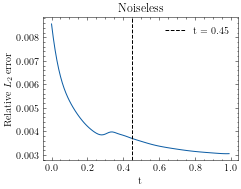

In [68]:
plt.plot(T[:, 0], performances)
plt.axvline(x=0.45, color='black', linestyle='--', label="t = 0.45")
plt.ylabel("Relative $L_{2}$ error")
plt.xlabel('t')
plt.title("Noiseless")
# plt.title("$u$ + Noise")
# plt.title("$u$ + Noise \& $(x, t)$ + Noise")
plt.legend(loc='best')
plt.savefig("./vis_pics/loss_plots/loss_plot_cleanall.png", dpi=300)
plt.show()

In [69]:
# save(semisup_model, "./weights_nobn/semisup_model_nobn_3000_3000_cleanall_unfinetuned.pth")

In [70]:
from l0bnb import fit_path

In [71]:
sols = fit_path(X_input.astype(np.float64), 
             np.ravel(y_input).astype(np.float64), 
             lambda_2 = 1e-2, max_nonzeros = 3, normalize=True, intercept=False)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  3


In [72]:
sols[-1]["B"]

array([-3.92243960e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.29647500e-02,  0.00000000e+00,  0.00000000e+00, -2.78928646e-06,
        0.00000000e+00,  0.00000000e+00])

In [73]:
poly_feature_names

['uf',
 'u_x',
 'u_xx',
 'u_xxx',
 'uf*u_x',
 'uf*u_xx',
 'uf*u_xxx',
 'u_x*u_xx',
 'u_x*u_xxx',
 'u_xx*u_xxx']

In [74]:
from abess import abessLm

In [75]:
abess_model = abessLm(always_select=[2], support_size=range(3))
abess_model.fit(X_input, y_input)

abessLm(always_select=[2], support_size=range(0, 3))

In [76]:
abess_model.coef_

array([ 0.        ,  0.        ,  0.00307263,  0.        , -0.96933081,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [77]:
# import pysindy as ps
# from pysindy import SINDy
# from pysindy.optimizers import STLSQ

# fl = ps.feature_library.PolynomialLibrary(degree=1, include_interaction=False, include_bias=False)
# opt = STLSQ(threshold=1e-4)
# model = SINDy(optimizer=opt, feature_library=fl, differentiation_method=None, feature_names=["u_xx", "uu_x"])

# model.fit(x=X_input[:, [2, 4]], x_dot=y_input, t=0.01)
# model.print()

In [78]:
# No selector network (Not the same as setting lambda_1 to 0.0) 
# varying lambda_{1} | lambda_{0} = 1e-5 or 1e-6 (the same results anyway)
# PDE derived using STRidge
# u_t = (0.002543 +0.000000i)u_xx
#     + (-0.832252 +0.000000i)uf*u_x

# 1e-1
# tensor([0.2735, 0.1883, 0.2060, 0.2133])
# u_t = (0.002695 +0.000000i)u_xx
#     + (-0.924525 +0.000000i)uf*u_x

# 1e-3
# tensor([0.8153, 0.8142, 0.4398, 0.1562])
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

# 1e-5
# tensor([0.6721, 0.7903, 0.7139, 0.3486])
# u_t = (0.002594 +0.000000i)u_xx
#     + (-0.885143 +0.000000i)uf*u_x

# varying lambda_{0} | lambda_{1} = 1e-3
# 1e-1
# PDE derived using STRidge
# u_t = (-0.066179 +0.000000i)uf*u_x

# 1e-3
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

# 1e-5
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x

In [79]:
# Goals!!!
# 3000 | eq found by STR | eq after PINN fine-tuning + mean error
# 1000 | eq found by STR | eq after PINN fine-tuning + mean error
# 500 | eq found by STR | eq after PINN fine-tuning + mean error

# 3000
# eq found by STR 
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x
# eq after PINN fine-tuning + mean error
# (-0.9994307160377502, 0.0031862353649783444)
# (0.07773227423228249, )

# 1000
# eq found by STR
# u_t = (0.002631 +0.000000i)u_xx
#     + (-0.860374 +0.000000i)uf*u_x
# eq after PINN fine-tuning + mean error
# (-0.9891335368156433, 0.0031485233921557665)
# (1.0864333669569826, 0.0002129514786863851)

# 500
# eq found by STR (failed)
# u_t = (-0.072116 +0.000000i)uf*u_x

In [80]:
# discover under [-1, 1]x[0, 0.45]

# Clean all
# [0.8153, 0.8142, 0.4398, 0.1562]
# u_t = (0.003090 +0.000000i)u_xx
#     + (-0.970158 +0.000000i)uf*u_x
# full domain
# u_t = (0.003073 +0.000000i)u_xx
#     + (-0.969320 +0.000000i)uf*u_x

# Clean (x, t), and noisy labels
# [0.7840, 0.7994, 0.4154, 0.2193]
# u_t = (0.002942 +0.000000i)u_xx
#     + (-0.961846 +0.000000i)uf*u_x
# full domain
# u_t = (0.002905 +0.000000i)u_xx
#     + (-0.925471 +0.000000i)uf*u_x

# Noisy (x, t), and noisy labels | relative l2 error = 0.06251628
# [0.7423, 0.7245, 0.6249, 0.2471]
# u_t = (0.005327 +0.000000i)u_xx
#     + (-0.826977 +0.000000i)uf*u_x
# full domain
# u_t = (0.001513 +0.000000i)u_xx
#     + (-0.506898 +0.000000i)uf*u_x